In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import seaborn as sns

In [4]:
count = np.sum(np.abs(M) < 0.00001)
print(count)

2


In [ ]:
def get_lambda_at(j1_target, j2_target, M, X, Y):
    """
    Return λ_max at the grid point (j1, j2) closest to (j1_target, j2_target).

    M : masked array, shape (Ny, Nx)
    X, Y : either
        - 1D arrays (len Nx, Ny), or
        - 2D arrays same shape as M (meshgrid)
    """

    if X.ndim == 1 and Y.ndim == 1:
        j1_vals = X
        j2_vals = Y
    else:
        # meshgrid-like
        j1_vals = X[0, :]   # vary along columns
        j2_vals = Y[:, 0]   # vary along rows

    # find nearest indices
    ix = np.argmin(np.abs(j1_vals - j1_target))  # column index
    iy = np.argmin(np.abs(j2_vals - j2_target))  # row index

    lam_val = M[iy, ix]      # masked scalar
    j1_near = j1_vals[ix]
    j2_near = j2_vals[iy]
    print(f"LLE at ({j1_near}, {j2_near}) is {lam_val}")

    return lam_val, j1_near, j2_near


In [50]:
get_lambda_at(3, -1, M, X, Y)

LLE at (3.0, -0.9933110367892977) is 0.15192990104117637


(0.15192990104117637, 3.0, -0.9933110367892977)

In [7]:
def select_points_by_lambda(M, X, Y, lower=None, upper=None):
    """
    Select grid points where λ_max is within (lower, upper) bounds.

    lower, upper : if not None, these are inclusive bounds:
        - lower: λ >= lower
        - upper: λ <= upper

    Returns:
        j1_sel, j2_sel, lam_sel
        where each is a 1D array of same length (number of selected points)
    """

    # Base mask: valid (non-masked) entries only
    if np.ma.isMaskedArray(M):
        data = M.data
        valid_mask = ~M.mask
    else:
        data = M
        valid_mask = np.ones_like(M, dtype=bool)

    # Apply lower/upper bounds
    cond = valid_mask.copy()
    if lower is not None:
        cond &= (data >= lower)
    if upper is not None:
        cond &= (data <= upper)

    # Build coordinate grids depending on X, Y layout
    if X.ndim == 1 and Y.ndim == 1:
        j1_grid, j2_grid = np.meshgrid(X, Y, indexing="xy")
    else:
        j1_grid, j2_grid = X, Y

    # Extract selected coordinates and values
    j1_sel = j1_grid[cond]
    j2_sel = j2_grid[cond]
    lam_sel = data[cond]

    return j1_sel, j2_sel, lam_sel


In [8]:
select_points_by_lambda(np.abs(M), X, Y, upper = 0.00002)

(array([-2.4180602 ,  0.33110368,  1.03344482,  0.85284281,  0.89297659,
         0.93311037]),
 array([-2.75919732, -1.39464883, -0.07023411,  0.89297659,  0.89297659,
         0.93311037]),
 array([9.93156802e-06, 1.25658634e-05, 7.70718525e-06, 1.10739718e-05,
        1.86058894e-05, 1.81395635e-05]))

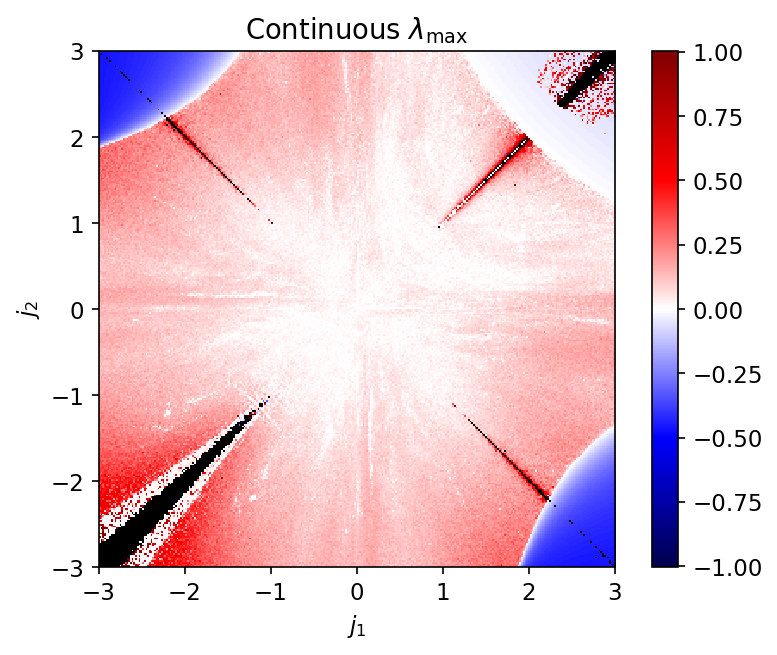

In [47]:
# -------- Load continuous LLE data --------
M = np.loadtxt("Data/M_LLE.csv", delimiter=",")
X = np.loadtxt("Data/X_LLE.csv", delimiter=",")
Y = np.loadtxt("Data/Y_LLE.csv", delimiter=",")

M_masked = np.ma.masked_invalid(M)

finite_vals = M_masked.compressed()
max_abs = np.max(np.abs(finite_vals)) if finite_vals.size > 0 else 1e-1
vmax = max_abs / 13
vmin = -max_abs / 13

cmap_LLE = plt.get_cmap("seismic").copy()
cmap_LLE.set_bad("black")

# -------- Plot --------
fig, ax = plt.subplots(figsize=(7, 4.5), dpi=150)

im = ax.imshow(
    M_masked,
    origin="lower",
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    cmap=cmap_LLE,
    vmin=vmin,
    vmax=vmax,
    aspect="equal",
    interpolation="nearest",
)

ax.set_title(r"Continuous $\lambda_{\max}$")
ax.set_xlabel(r"$j_1$")
ax.set_ylabel(r"$j_2$")

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig.tight_layout()
fig.savefig("Plots/LLE_heat.png", dpi=150, bbox_inches="tight")
plt.show()


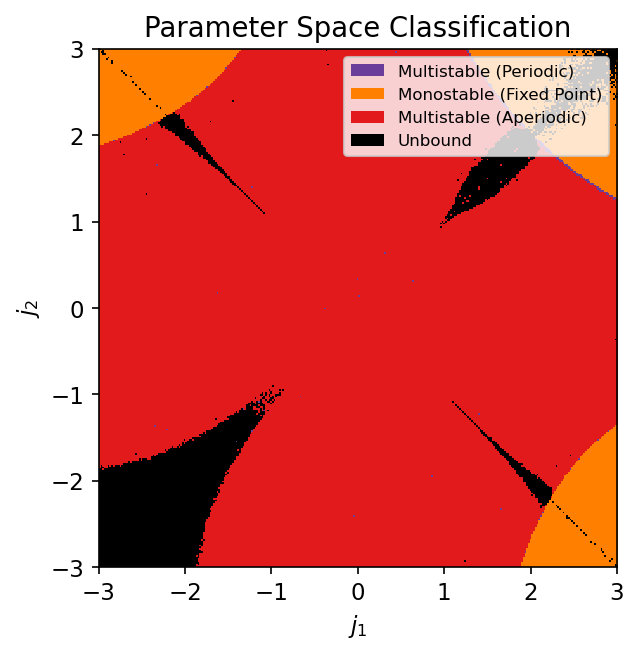

In [ ]:
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# -------- Load discrete classification --------
M_disc = np.loadtxt("Data/M.csv", delimiter=",", dtype=int)
X = np.loadtxt("Data/X.csv", delimiter=",")
Y = np.loadtxt("Data/Y.csv", delimiter=",")

# -------- Group into 0,1,2,3 classes --------
M_group = np.zeros_like(M_disc, dtype=int)
M_group[(M_disc == 1) | (M_disc == 4)] = 1     # Multistable periodic
M_group[M_disc == 2] = 2                       # Fixed point
M_group[M_disc == 5] = 3                       # Multistable aperiodic

colors_grouped = ["#000000", "#6a3d9a", "#ff7f00", "#e31a1c"]
cmap_grouped = ListedColormap(colors_grouped)
norm_grouped = BoundaryNorm(np.arange(-0.5, 4.5), cmap_grouped.N)

# -------- Plot --------
fig, ax = plt.subplots(figsize=(7, 4.5), dpi=150)

im = ax.imshow(
    M_group,
    origin="lower",
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    cmap=cmap_grouped,
    norm=norm_grouped,
    aspect="equal",
    interpolation="nearest",
)

ax.set_title("Parameter Space Classification")
ax.set_xlabel(r"$j_1$")
ax.set_ylabel(r"$j_2$")

legend_elems = [
    Patch(facecolor="#6a3d9a", label="Multistable (Periodic)"),
    Patch(facecolor="#ff7f00", label="Monostable (Fixed Point)"),
    Patch(facecolor="#e31a1c", label="Multistable (Aperiodic)"),
    Patch(facecolor="#000000", label="Unbound"),
]
ax.legend(handles=legend_elems, fontsize=8, loc="upper right")

fig.tight_layout()
fig.savefig("Plots/parameter_space_class.png", dpi=150, bbox_inches="tight")
plt.show()

/opt/anaconda3/envs/CompMaths/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Robust smoothing window = 20
MAD = 5.849e-03, outliers flagged = 109


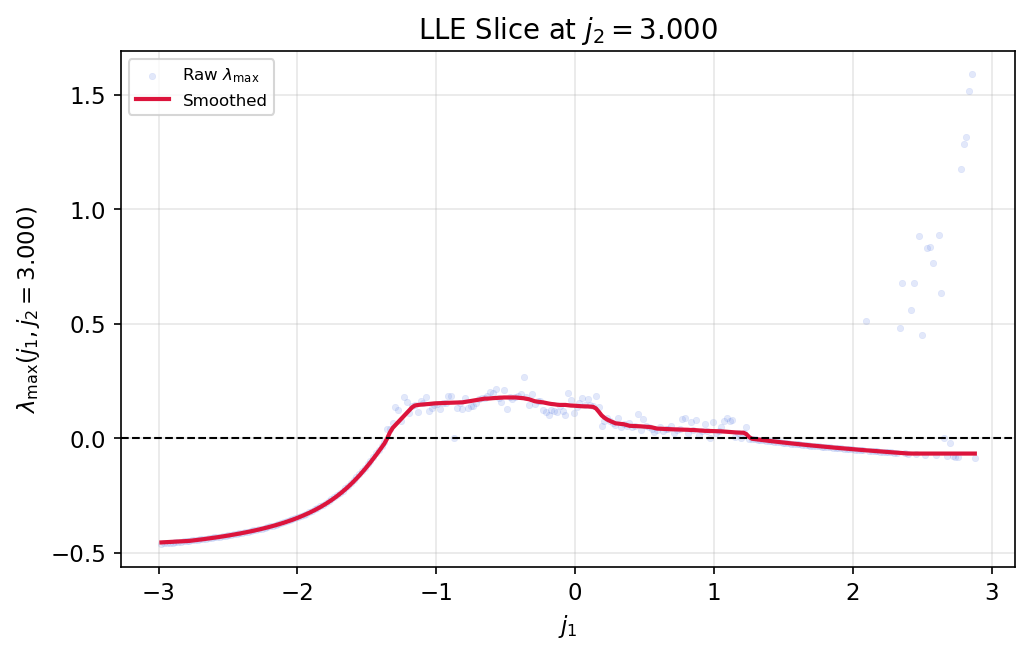

In [ ]:
# ------------------------------------------------------
# Load Lyapunov data (continuous λ_max)
# ------------------------------------------------------
LLE = np.loadtxt("Data/M_LLE.csv", delimiter=",")
X_LLE = np.loadtxt("Data/X_LLE.csv", delimiter=",")
Y_LLE = np.loadtxt("Data/Y_LLE.csv", delimiter=",")

LLE_masked = np.ma.masked_invalid(LLE)

# ------------------------------------------------------
# Choose j2 slice and extract λ_max(j1, j2_target)
# ------------------------------------------------------
j2_target = 3.0   # <<< set this to the j2 you want
idx = np.argmin(np.abs(Y_LLE - j2_target))

lambda_slice = LLE_masked[idx, :]    # masked row
j1_vals = X_LLE

# Clean NaNs if masked
if hasattr(lambda_slice, "mask"):
    mask = ~lambda_slice.mask
    j1_clean = j1_vals[mask]
    lambda_clean = lambda_slice[mask]
else:
    j1_clean = j1_vals
    lambda_clean = lambda_slice

# ------------------------------------------------------
# OUTLIER-ROBUST SMOOTHING OF λ_max(j1, j2_target)
# ------------------------------------------------------

# window size (≈ 2% of data)
window_points = max(20, len(lambda_clean) // 50)

# 1) Rolling median baseline
baseline = (
    pd.Series(lambda_clean)
    .rolling(window=window_points, center=True, min_periods=1)
    .median()
    .to_numpy()
)

# 2) Residuals + MAD
resid = lambda_clean - baseline
mad = np.median(np.abs(resid))
mad = mad if mad > 0 else np.std(resid) + 1e-12

k = 2.0  # outlier threshold in MAD units
outlier_mask = np.abs(resid) > k * mad

print(f"Robust smoothing window = {window_points}")
print(f"MAD = {mad:.3e}, outliers flagged = {outlier_mask.sum()}")

# 3) Interpolate over outliers
lambda_inliers = lambda_clean.copy()
lambda_inliers[outlier_mask] = np.nan
lambda_inliers = (
    pd.Series(lambda_inliers)
    .interpolate(limit_direction="both")
    .to_numpy()
)

# 4) Final robust smooth curve
lambda_smooth = (
    pd.Series(lambda_inliers)
    .rolling(window=window_points, center=True, min_periods=1)
    .median()
    .to_numpy()
)

# ------------------------------------------------------
# FIGURE: LLE slice (raw + smoothed)
# ------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 4.5), dpi=150)

# raw curve
ax.scatter(
    j1_clean,
    lambda_clean,
    linewidth=0.2,
    s=10,
    color="royalblue",
    alpha=0.15,
    label=r"Raw $\lambda_{\max}$",
)

# smoothed curve
ax.plot(
    j1_clean,
    lambda_smooth,
    linewidth=2.0,
    color="crimson",
    label="Smoothed",
)

ax.axhline(0, color="k", linestyle="--", linewidth=1)

ax.set_xlabel(r"$j_1$")
ax.set_ylabel(r"$\lambda_{\max}(j_1, j_2 = %.3f)$" % Y_LLE[idx])
ax.set_title(r"LLE Slice at $j_2 = %.3f$" % Y_LLE[idx])

ax.legend(loc="best", fontsize=8)
ax.grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig("Plots/LLE_slice.png", dpi=300, bbox_inches="tight")
plt.show()
